<a href="https://colab.research.google.com/github/leonardosva/mvp_cnh/blob/main/MVP_CNH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Renovação Carteira Nacional de Habilitação - CNH #
As regras para renovação da CNH mudaram em dezembro de 2021, de acordo com a Lei nº 14.404/2022. Agora, o prazo de validade da CNH varia de acordo com a idade do condutor e atividade remunerada:

**REGRAS PARA RENOVAÇÂO DE CONDUTOR:**

Idade do motorista ----  Validade / Renovação

Até 49 anos--------------10 anos.

Entre 50 e 69 anos-------5 anos.

Mais de 70 anos----------3 anos.

- A ideia é analisar preditivamente os contudores com CNH's validas / vencidas e identificar o fluxo de renovação dentro do prazo legal.

Utilizei modelos de acordo com as aulas de machine learning para analisar/tratar o problema de classificação.

**>>>> Dataset <<<<<**

 O dataset possui 9000 instâncias e 5 atributos, entre dados categóricos e numéricos:

Colunas:
- Idade: idade do condutor
- CAR_STR_ID_CATEGORIA: categoria da cnh
- CAR_STR_ID_TIPO: Condutor (C) ou Permissionario (P).
- CAR_DAT_DT_EMISSAO: Data da emissão da CNH.
- CAR_DAT_DT_VALIDADE: Data de Validade da CNH.
- RENOVACAO: Classe de saída: 0 - RENOVAR e 1 - NAO RENOVAR










**Realizar as importações necessárias para o projeto**

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd # para importação do dataset
import numpy as np #
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imblearn.over_sampling import SMOTE # tratamento do balanceamento por Oversampling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # realiza o ajuste de escalonamento
from sklearn.preprocessing import LabelEncoder # para converter variáveis categóticas
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold # estratificação dos Kfolds
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # para matriz de confusão
from sklearn.pipeline import Pipeline # para criação dos pipelines
from sklearn.linear_model import LogisticRegression # algorítmo de regressão logistica
from sklearn.tree import DecisionTreeClassifier # algorítmos arvore de classificação
from sklearn.neighbors import KNeighborsClassifier # algorítmos KNN
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVC
from sklearn.ensemble import BaggingClassifier # ensemble Bagging
from sklearn.ensemble import RandomForestClassifier # ensemble RF
from sklearn.ensemble import ExtraTreesClassifier # ensemble ExtraTree
from sklearn.ensemble import VotingClassifier # ensemblre Voting
from sklearn.ensemble import AdaBoostClassifier # ensembel ADA Boost
from sklearn.ensemble import GradientBoostingClassifier # ensemble GradientBoost
from sklearn.ensemble import HistGradientBoostingClassifier # ensemble GradientBoost
from statistics import mean

**Carregando os dados históricos da base de consignado**

In [2]:
# Carregar os dados

url = "https://raw.githubusercontent.com/leonardosva/mvp_cnh/main/dataset_cnh.csv"
data_cnh = pd.read_csv(url, delimiter=';') # leitura do dataset CNH
data_cnh.head(10) # exibição das 10 primeiras linhas do dataset CNH

,IDADE,CATEGORIA,TIPO,EMISSAO,VALIDADE,RENOVACAO
0,60,AD,C,02/10/2004,30/09/2009,1
1,51,B,C,02/10/2004,30/09/2009,1
2,56,B,C,02/10/2004,30/09/2009,1
3,74,B,C,02/10/2004,30/09/2009,1
4,50,C,C,02/10/2004,30/09/2009,1
5,71,AC,C,02/10/2004,30/09/2009,1
6,44,B,C,02/10/2004,30/09/2009,1
7,73,AB,C,02/10/2004,30/09/2009,1
8,50,B,C,02/10/2004,30/09/2009,1
9,-24,B,C,02/10/2004,30/09/2009,1


**Verificando o desbalanceamento e discrepâncias do Datast CNH**

In [3]:
# Verificando o desbalanceamento e discrepâncias do Datast CNH
data_cnh.describe()

,IDADE,RENOVACAO
count,8000.000000,8000.000000
mean,48.242625,0.625000
std,22.869825,0.484153
min,-25.000000,0.000000
25%,45.000000,0.000000
50%,54.000000,1.000000
75%,61.000000,1.000000
max,74.000000,1.000000


*** Podemos observar um desvio em relação a idade (idade negativa), Legistação vigente permitem CNH apenas para maiores de 18 anos.**

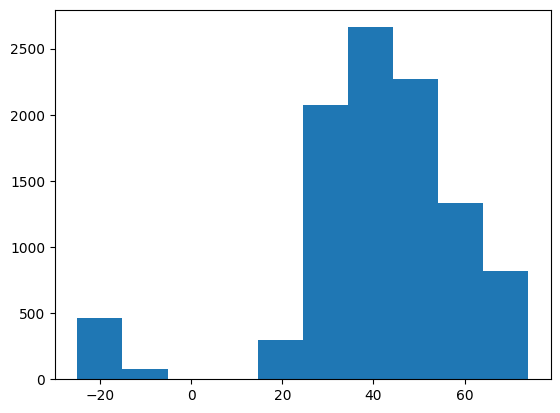

In [100]:
# Plotando a distribuição da idade em relação a base CNH
plt.hist(x=data_cnh['IDADE']);

**Tratativas de valores divergentes no Dataset CNH**
- Após análise dos dados, realizaremos o tratamento de valores divergentes . No caso, encontramos algumas idades menor que 0.

In [101]:
# Filtragem das idade negativas
data_cnh[data_cnh['IDADE'] <= 0]

,IDADE,CAR_STR_ID_CATEGORIA,CAR_STR_ID_TIPO,CAR_DAT_DT_EMISSAO,CAR_DAT_DT_VALIDADE,RENOVACAO
5,-15,B,C,29/01/2022,28/12/2024,1
7,-24,B,C,26/01/2022,23/12/2024,1
44,-21,B,C,26/01/2022,04/01/2025,1
45,-22,B,C,26/01/2022,29/12/2024,1
55,-14,B,C,26/01/2022,04/01/2025,1
...,...,...,...,...,...,...
4258,-25,B,C,04/02/2022,06/12/2024,1
4297,-25,B,C,04/02/2022,13/01/2025,1
4313,-14,B,C,04/02/2022,17/01/2025,1
4364,-16,B,C,27/01/2022,17/01/2025,1


In [102]:
# Adotaremos Idade > 0  para correção sem considerar os valores idade < 0
drop = data_cnh[data_cnh['IDADE']<0].index
data_cnh = data_cnh.drop(drop,axis=0)

In [103]:
# Exibindo o dataset CNH sem idade negativas
data_cnh.describe()

,IDADE,RENOVACAO
count,9463.000000,9463.000000
mean,44.539998,0.408221
std,12.958132,0.491531
min,22.000000,0.000000
25%,34.000000,0.000000
50%,43.000000,0.000000
75%,53.000000,1.000000
max,74.000000,1.000000


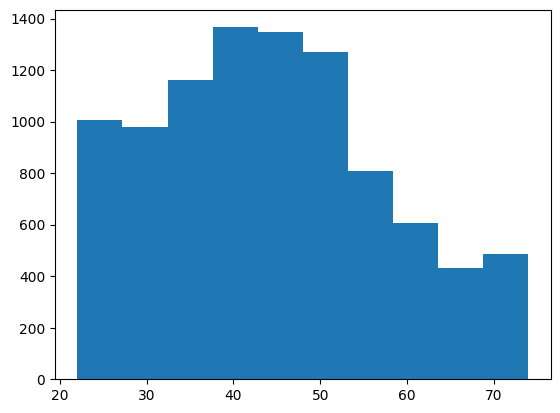

In [104]:
# Plotando a distribuição da idade em relação a base após a correção
plt.hist(x=data_cnh['IDADE']);

**Verificando valores faltantes (Não encontrado)**

In [105]:
# Buscar null em todos os registros
data_cnh.isnull().sum()

IDADE                   0
CAR_STR_ID_CATEGORIA    0
CAR_STR_ID_TIPO         0
CAR_DAT_DT_EMISSAO      0
CAR_DAT_DT_VALIDADE     0
RENOVACAO               0
dtype: int64

**Análise de balanceamento por Oversampling**

In [106]:
# Funcão para contar os valores únicos da coluna "RENOVACAO" e verificar o balanceamento
np.unique(data_cnh['RENOVACAO'], return_counts=True)

(array([0, 1]), array([5600, 3863]))

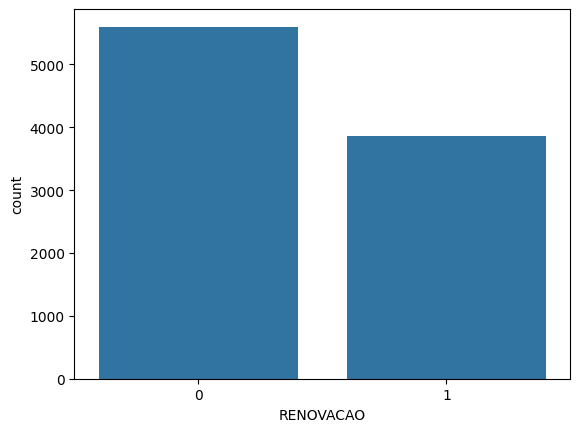

In [107]:
# Plotando em gráfico o balanceamento
sns.countplot(x=data_cnh['RENOVACAO']);

In [108]:
# Dividir entre previsores e classes
X_cnh = data_cnh.drop('RENOVACAO', axis=1)
y_cnh = data_cnh[['RENOVACAO']]

# Codificar variáveis categóricas
label_encoder_tipo = LabelEncoder()
label_encoder_cat = LabelEncoder()
label_encoder_emissao = LabelEncoder()
label_encoder_validade = LabelEncoder()

X_cnh.iloc[:,1] = label_encoder_tipo.fit_transform(X_cnh.iloc[:,1])
X_cnh.iloc[:,2] = label_encoder_cat.fit_transform(X_cnh.iloc[:,2])
X_cnh.iloc[:,3] = label_encoder_emissao.fit_transform(X_cnh.iloc[:,3])
X_cnh.iloc[:,4] = label_encoder_validade.fit_transform(X_cnh.iloc[:,4])

# Holdout
X_cnh_training, X_cnh_test, y_cnh_training, y_cnh_test = train_test_split(X_cnh, y_cnh)


In [109]:
# Funcão para validação cruzada
def cross_validation(model, X_cnh, y_cnh, oversampling=False):
    kfold = KFold(n_splits=10)

    # lista de acurácias de cada split
    accuracy_split = []

    for idx,(idx_training, idx_validation) in enumerate(kfold.split(X_cnh)):
        X_split_training = X_cnh.iloc[idx_training,:]
        y_split_training = y_cnh.iloc[idx_training,:]

        # oversampling, só no split de treino!
        if oversampling:
            sm = SMOTE(random_state=42)
            X_split_training, y_split_training = sm.fit_resample(X_split_training, y_split_training)

        # Treinando o modelo
        model.fit(X_split_training, y_split_training.values.flatten())

        X_split_validation = X_cnh.iloc[idx_validation, :]
        y_split_validation = y_cnh.iloc[idx_validation, :]

        # Validação SEM oversampling
        predict_validation = model.predict(X_split_validation)

        acuracia_split = accuracy_score(y_split_validation, predict_validation)

        accuracy_split.append(acuracia_split)

        print(f'Acurácia do split {idx}: {accuracy_split}')
    return accuracy_split

In [110]:
# Criando o modelo
model_hgb = HistGradientBoostingClassifier()

mean_accuracy_with_smote = mean(cross_validation(model_hgb, X_cnh_training, y_cnh_training, oversampling=False))
mean_accuracy_no_smote = mean(cross_validation(model_hgb, X_cnh_training, y_cnh_training, oversampling=True))

f'No smote: {mean_accuracy_no_smote:.02f}, with_smo: {mean_accuracy_with_smote:.02f}'

Acurácia do split 0: [0.9746478873239437]
Acurácia do split 1: [0.9746478873239437, 0.9943661971830986]
Acurácia do split 2: [0.9746478873239437, 0.9943661971830986, 0.971830985915493]
Acurácia do split 3: [0.9746478873239437, 0.9943661971830986, 0.971830985915493, 0.9690140845070423]
Acurácia do split 4: [0.9746478873239437, 0.9943661971830986, 0.971830985915493, 0.9690140845070423, 0.9901408450704225]
Acurácia do split 5: [0.9746478873239437, 0.9943661971830986, 0.971830985915493, 0.9690140845070423, 0.9901408450704225, 0.9774647887323944]
Acurácia do split 6: [0.9746478873239437, 0.9943661971830986, 0.971830985915493, 0.9690140845070423, 0.9901408450704225, 0.9774647887323944, 0.9746478873239437]
Acurácia do split 7: [0.9746478873239437, 0.9943661971830986, 0.971830985915493, 0.9690140845070423, 0.9901408450704225, 0.9774647887323944, 0.9746478873239437, 0.9760225669957687]
Acurácia do split 8: [0.9746478873239437, 0.9943661971830986, 0.971830985915493, 0.9690140845070423, 0.9901408

'No smote: 0.97, with_smo: 0.98'

- Com Oversampling = 0,98
- Sem Oversampling = 0,98

** Utilizando uma base de treinamento isolada, aplicamos Oversampling, que consiste em gerar novos exemplos para a classe minoritária, de forma a aumentar sua representatividade no conjunto de dados.

Como não houve ganho aplicando Oversampling, não será utilizado.



**Divisão das bases em treinamento e teste. No caso, dividiremos a base de treinamento em 70% e teste com 30%.**

In [111]:
# Divisão das bases de treinamento e teste
# Transformando as variáveis para numpy
X_cnh = X_cnh.values
y_cnh = y_cnh.values
X_cnh_training, X_cnh_test, y_cnh_training, y_cnh_test = train_test_split(X_cnh, y_cnh, test_size=0.30, random_state=10) #
X_cnh_training.shape, y_cnh_training.shape # Exibindo a dimensionalidade da base de treinamento

((6624, 5), (6624, 1))

In [112]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=10) # validação cruzada com estratificação

LR: 0.697763 (0.015171)
KNN: 0.860965 (0.010114)
CART: 0.922254 (0.009728)
NB: 0.710750 (0.012125)
SVM: 0.708939 (0.009699)
Bagging: 0.938106 (0.008762)
RF: 0.935540 (0.008964)
ET: 0.914259 (0.013033)
Ada: 0.871381 (0.010919)
GB: 0.910932 (0.010174)
Voting: 0.753921 (0.009182)


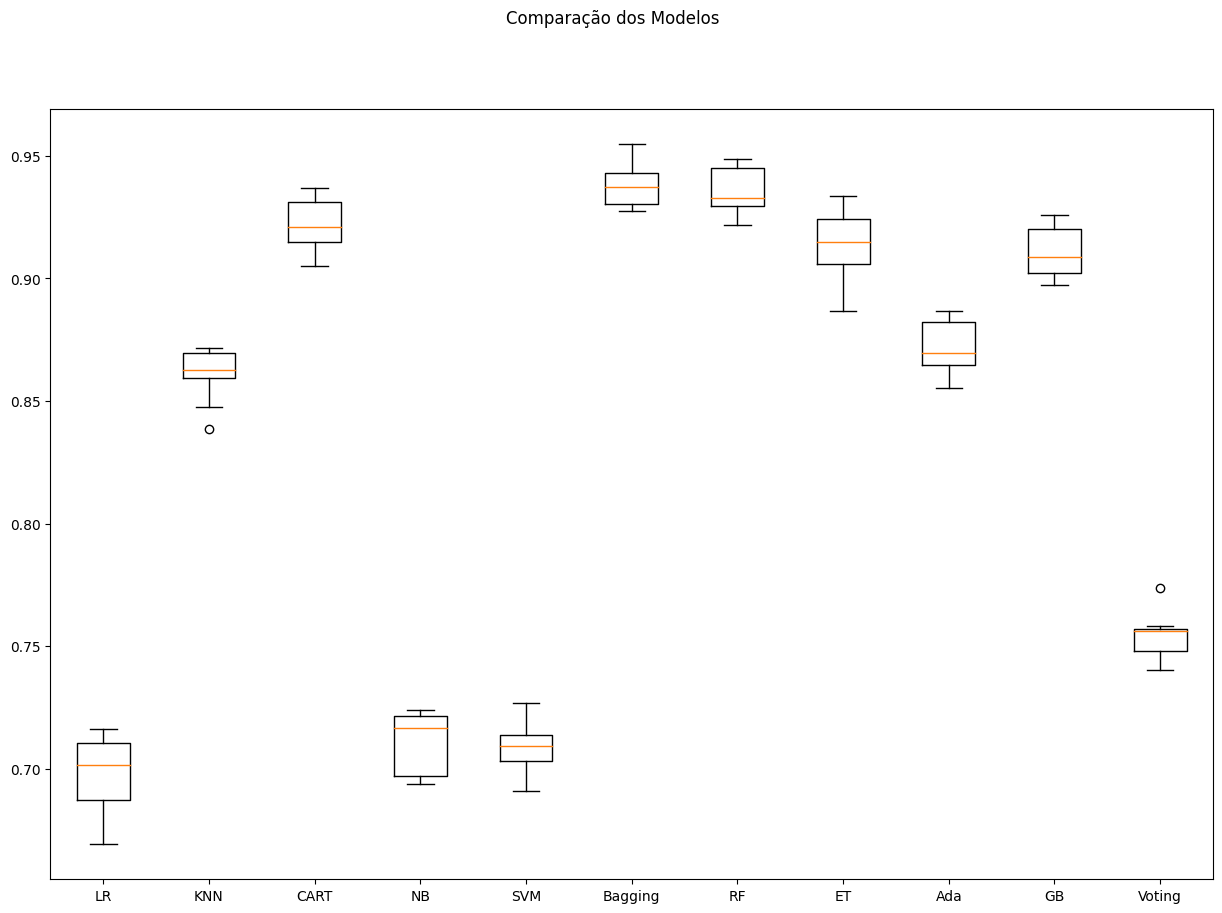

In [113]:
# Modelagem e Inferência
# Criação e avaliação de modelos: linha base
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_cnh_training, y_cnh_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR-orig: 0.698 (0.015)
KNN-orig: 0.861 (0.010)
CART-orig: 0.922 (0.010)
NB-orig: 0.711 (0.012)
SVM-orig: 0.709 (0.010)
Bag-orig: 0.938 (0.009)
RF-orig: 0.936 (0.009)
ET-orig: 0.914 (0.013)
Ada-orig: 0.871 (0.011)
GB-orig: 0.911 (0.010)
Vot-orig: 0.754 (0.009)
LR-padr: 0.698 (0.015)
KNN-padr: 0.847 (0.012)
CART-padr: 0.923 (0.011)
NB-padr: 0.711 (0.012)
SVM-padr: 0.782 (0.015)
Bag-padr: 0.935 (0.011)
RF-padr: 0.934 (0.009)
ET-padr: 0.913 (0.015)
Ada-padr: 0.871 (0.011)
GB-padr: 0.911 (0.010)
Vot-padr: 0.819 (0.010)
LR-norm: 0.699 (0.015)
KNN-norm: 0.846 (0.014)
CART-norm: 0.923 (0.009)
NB-norm: 0.711 (0.012)
SVM-norm: 0.782 (0.017)
Bag-norm: 0.938 (0.010)
RF-norm: 0.935 (0.010)
ET-norm: 0.913 (0.015)
Ada-norm: 0.871 (0.011)
GB-norm: 0.911 (0.010)
Vot-norm: 0.823 (0.010)


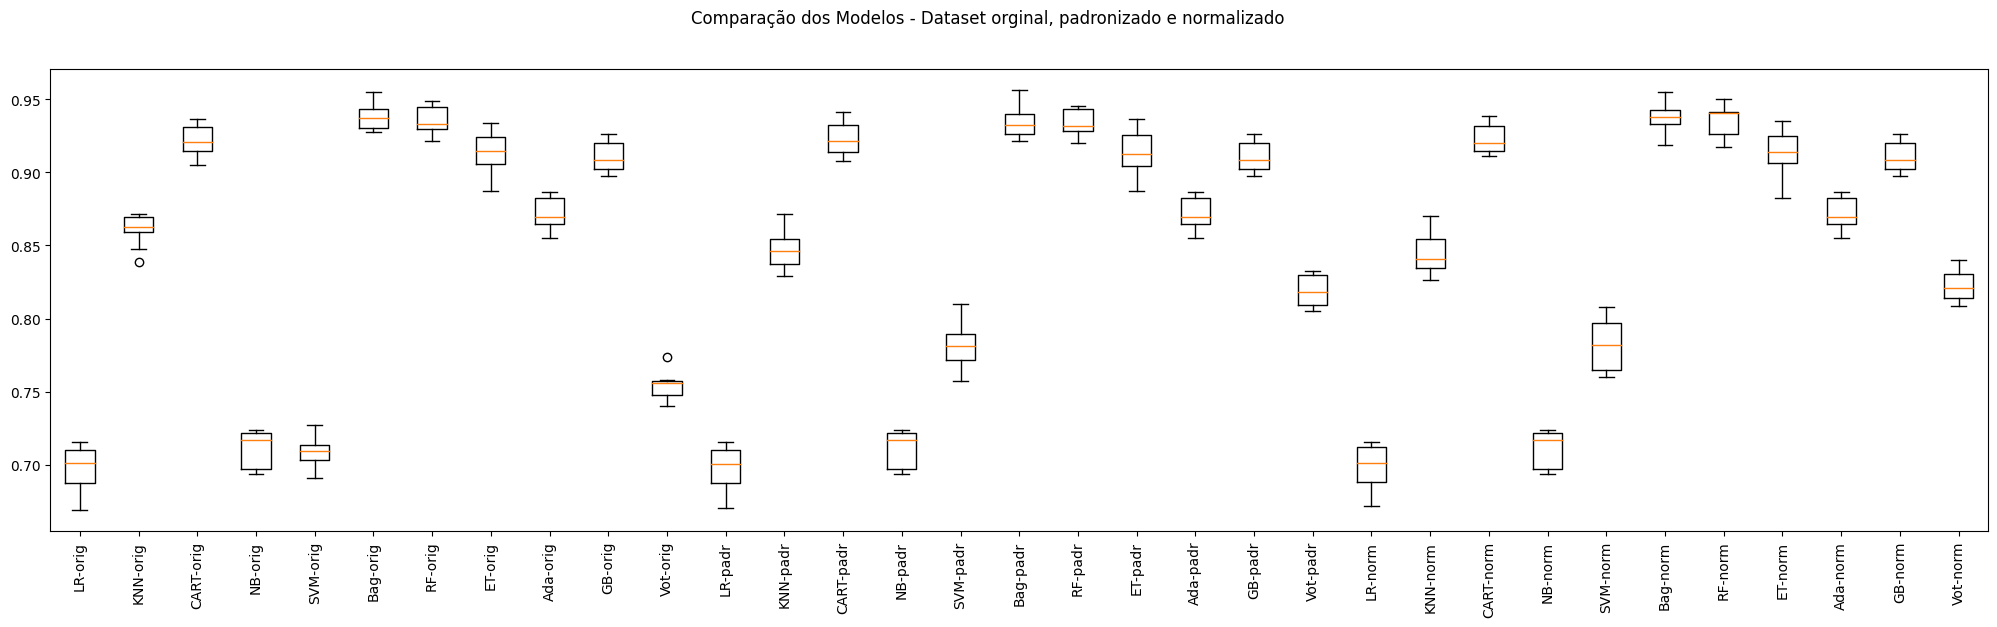

In [114]:
# Criação e avaliação de modelos: dados padronizados e normalizados

np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())



# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_cnh_training, y_cnh_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

In [115]:
# Otimização dos hiperparâmetros
# Tuning do BaggingClassifier

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
#random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
#gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

#GradientBoostingClassifier
#pipelines.append(('GB-orig', Pipeline(steps=[gradient_boosting])))
#pipelines.append(('GB-padr', Pipeline(steps=[standard_scaler, gradient_boosting])))
#pipelines.append(('GB-norm', Pipeline(steps=[min_max_scaler, gradient_boosting])))

#param_grid = {
#    'GB__n_estimators': [50,75,100],
#    'GB__max_features': [0.5, 1.0, 1.5],
#    'GB__max_depth': [5, 10, 15],
#}

#BaggingClassifier
pipelines.append(('Bag-orig', Pipeline(steps=[bagging])))
pipelines.append(('Bag-padr', Pipeline(steps=[standard_scaler, bagging])))
pipelines.append(('Bag-norm', Pipeline(steps=[min_max_scaler, bagging])))

param_grid = {
    'Bag__n_estimators': [50,75,100],
    'Bag__max_features': [0.5, 1.0, 1.5],
    'Bag__max_samples':[2, 3, 4, 5],
}

#RandomForestClassifier
#pipelines.append(('RF-orig', Pipeline(steps=[random_forest])))
#pipelines.append(('RF-padr', Pipeline(steps=[standard_scaler, random_forest])))
#pipelines.append(('RF-norm', Pipeline(steps=[min_max_scaler, random_forest])))

#param_grid = {
#    'RF__n_estimators': [10,50,100],
#    'RF__max_depth': [5, 10, 15],
#    'RF__criterion': ['gini','entropy','log_loss'],
#    'RF__max_features': [0.5, 1.0, 1.5],
#}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_cnh_training, y_cnh_training)
    # imprime a melhor configuração
    #print("Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))
    print(name,grid.best_score_,grid.best_params_)

Bag-orig 0.6924844955411865 {'Bag__max_features': 1.0, 'Bag__max_samples': 5, 'Bag__n_estimators': 100}
Bag-padr 0.6858425266457966 {'Bag__max_features': 1.0, 'Bag__max_samples': 4, 'Bag__n_estimators': 100}
Bag-norm 0.6918713802044174 {'Bag__max_features': 1.0, 'Bag__max_samples': 5, 'Bag__n_estimators': 100}


In [116]:
# Finalização do Modelo
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_cnh_training) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_cnh_training) # aplicação da padronização no conjunto de treino
#model = RandomForestClassifier(n_estimators=100, max_features=1.0, criterion='log_loss', max_depth=15)
model = BaggingClassifier(n_estimators=100, max_features=1.0, estimator=base, max_samples=5)
#model = GradientBoostingClassifier(n_estimators=100, max_features=1.0, max_depth=15)


model.fit(rescaledX, y_cnh_training)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_cnh_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_cnh_test, predictions))

0.6872138076787602


In [117]:
# Preparação do modelo com TODO o dataset CNH
scaler = StandardScaler().fit(X_cnh) # ajuste do scaler com TODO o dataset CNH
rescaledX = scaler.transform(X_cnh) # aplicação da padronização com TODO o dataset CNH
model.fit(rescaledX, y_cnh)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=5,
                  n_estimators=100)

In [118]:
# Matriz de confusão
confusion_matrix(y_cnh_test, predictions)

array([[1573,   77],
       [ 811,  378]])

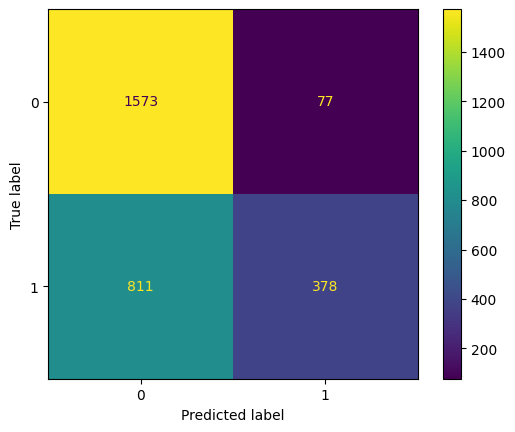

In [119]:
# Visualizando através do gráfico da matriz de confusão
cm = confusion_matrix(y_cnh_test, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()

**Análise da Matriz de Confusão**

- Verdadeiro Positivo: 859 - Quando o classificador previu SIM (RENOVAR = 0) e a classe correta é SIM (RENOVAR=0)
- Verdadeiro Negativo: 1140 - Quando o classificador previu NÂO (RENOVAR = 1) e a classe correta é NÂO (REVOVAR=1)
- Falso Positivo: 7 - Quando o classificador previu SIM (RENOVAR = 0) e a classe correta é NÂO (RENOVAR = 1)
- Falso Negativo: 16 - Quando o classificador previu NÂO (RENOVAR = 1) e a classe correta é SIM (RENOVAR = 0)

Total de Registros: 2024
Taxa de acerto (acurácia): (859 + 1140) / 2024 = 0,9886


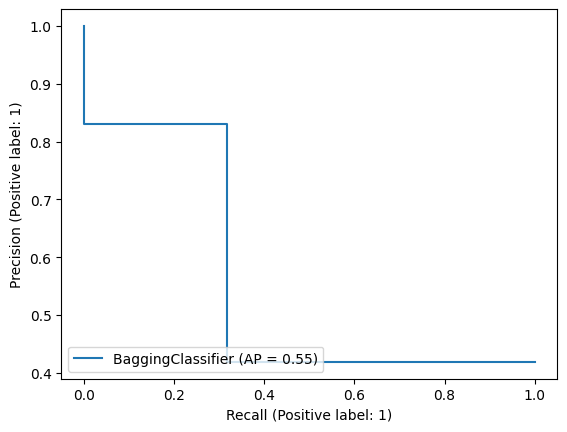

In [120]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_cnh_test, predictions, name="BaggingClassifier")
plt.show()

Análise de Precisão

**Precision**

Quando o modelo previu SIM, o quanto ele estava certo?
- 860 / (860 + 7) = 0,986
- Foi identificado pelo modelo corretamente 98% para renovação CNH no ano vigente.

Análise de Precisão

**Recall**
- 859 / 859 + 6) = 0,989
- Foi identificado pelo modelo corretamente 98% em toda a dataset para renovação CNH no ano vigente.


In [121]:
# Simulando a aplicação do modelo em dados não vistos
# Novos dados - não sabemos a classe!
#IDADE	CATEGORIA	TIPO	EMISSAO	VALIDADE	RENOVACAO
data = {'IDADE': [73],
        'CATEGORIA': ['B'],
        'TIPO':['C'],
        'EMISSAO': ['26/01/2022'],
        'VALIDADE': ['04/01/2024'],
       }

atributos = ['IDADE','CATEGORIA','TIPO','EMISSAO','VALIDADE']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:5]

# Codificar variáveis categóricas
label_encoder_cat = LabelEncoder()
label_encoder_tipo = LabelEncoder()
label_encoder_emissao = LabelEncoder()
label_encoder_validade = LabelEncoder()

X_entrada[:,1] = label_encoder_cat.fit_transform(X_entrada[:,1])
X_entrada[:,2] = label_encoder_tipo.fit_transform(X_entrada[:,2])
X_entrada[:,3] = label_encoder_emissao.fit_transform(X_entrada[:,3])
X_entrada[:,4] = label_encoder_validade.fit_transform(X_entrada[:,4])

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 2.1964204  -3.19583322  0.         -1.22713439 -1.73967505]]


In [122]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0]


# Analisando os valores obtidos na saída, entendi que o modelo interpretou de acordo com o esperado, interpretou a regra de negócio. .

